<a href="https://colab.research.google.com/github/abdullahmujahidali/Vet-LangGraph/blob/main/VetAI_CustomPrompts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q langchain langgraph langchain_openai openai pinecone langchain_community pymupdf langsmith

import os
import time
import asyncio
import base64
from dataclasses import dataclass
import json
import fitz
from typing import List, Dict, Tuple, Annotated, TypedDict, Union, Any, Optional, Literal
from IPython.display import Image, display
import traceback

from datetime import datetime
from enum import Enum
from concurrent.futures import ThreadPoolExecutor
from functools import partial
import logging

from google.colab import userdata
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage, AIMessage
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader
from pinecone import Pinecone
import operator




# LANGSMITH_ENDPOINT="https://api.smith.langchain.com"
# LANGSMITH_API_KEY=userdata.get('LANGSMITH_API_KEY')
# LANGSMITH_PROJECT="VetAI-Non-Parallel"

OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
PINECONE_API_KEY = userdata.get('PINECONE_API_KEY')
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ['PINECONE_API_KEY'] = PINECONE_API_KEY

# os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
# os.environ["LANGCHAIN_API_KEY"] = LANGSMITH_API_KEY
# os.environ["LANGCHAIN_PROJECT"] = LANGSMITH_PROJECT


llm = ChatOpenAI(
    model="gpt-3.5-turbo",
    )

pc = Pinecone(
    api_key=os.getenv("PINECONE_API_KEY")
)

index_name = "veterinary-ai-index"
embeddings = OpenAIEmbeddings()


class VetState(TypedDict):
    messages: Annotated[List[Union[dict, str]], operator.add]
    current_input: Annotated[str, operator.add]
    medical_records: Annotated[Dict[str, Any], operator.or_]
    results: Annotated[Dict[str, Any], operator.or_]
    metadata: Annotated[Dict[str, Any], operator.or_]
    context: Annotated[List[str], operator.add]
    images: Annotated[List[Dict[str, Any]], operator.add]
    history_results: Annotated[List[str], operator.add]
    clinical_results: Annotated[List[str], operator.add]
    timings: Annotated[Dict[str, float], operator.or_]


import time

def track_time(agent_name):
    def decorator(func):
        def wrapper(state: VetState) -> VetState:
            start_time = time.time()
            result = func(state)
            duration = time.time() - start_time
            new_state = result.copy()
            if "timings" not in new_state:
                new_state["timings"] = {}
            new_state["timings"][agent_name] = duration
            return new_state
        return wrapper
    return decorator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.4/151.4 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.4/421.4 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.7/413.7 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.2 MB/s eta 0:00:00


In [2]:
@dataclass
class VetPrompts:
    """Collection of prompts for veterinary analysis agents"""

    BASE_VETERINARY_CONTEXT = """You are a veterinary specialist creating detailed medical documentation.
    CRITICAL REQUIREMENTS:
    - Document ALL numerical values with exact measurements and units
    - Record ALL dates in MM/DD/YY format with specific times when available
    - Use precise medical terminology without generalizations
    - Note EVERY abnormal finding with detailed descriptions
    - Include ALL diagnostic results with reference ranges
    - Document ALL medications with exact names, doses, frequencies, and routes
    - Record ALL client communications and instructions"""

    DATA_PROCESSOR = """You are a veterinary data processing agent conducting initial case review.

    REQUIRED DOCUMENTATION FORMAT:

    PATIENT SIGNALMENT & CLIENT INFORMATION:
    - Full patient details (ID#, name, species, breed, age, sex, weight to 0.1kg)
    - Complete client contact information
    - ALL current medications with exact doses/frequencies/routes
    - Insurance status and billing preferences

    PRESENTING COMPLAINT AND HISTORY:
    [Chief Complaint]
    - Exact duration of symptoms (days/weeks/months)
    - Precise progression timeline with specific dates
    - Detailed symptom frequency and severity patterns
    - ALL changes in behavior, appetite, drinking, urination, defecation

    [Past Medical History]
    - Complete chronological medical history with dates
    - ALL previous medications/treatments with responses
    - EVERY vaccination/preventive care date and product
    - ALL prior surgeries/procedures
    - Complete diet history with brands/amounts/frequencies

    PHYSICAL EXAMINATION:
    - ALL vital signs with exact values:
      * Temperature (°F to 0.1 degree)
      * Heart rate (beats/min)
      * Respiratory rate (breaths/min)
      * Weight (kg to 0.1)
      * Body condition score (1-9 scale)
      * Mucous membrane color
      * Capillary refill time (seconds)
      * Pain score (0-10 scale)

    - Detailed system-by-system examination:
      * EENT (including ALL abnormalities in eyes, ears, nose, throat)
      * Cardiovascular (heart sounds, pulses, rhythm)
      * Respiratory (breathing pattern, lung sounds, cough characteristics)
      * Gastrointestinal (including oral exam findings)
      * Musculoskeletal (gait, range of motion, pain responses)
      * Neurologic (detailed reflex and response testing)
      * Integumentary (ALL skin/coat abnormalities)
      * Lymphatic (ALL node sizes/characteristics)
      * Urogenital (including external genitalia examination)

    DIAGNOSTIC FINDINGS:
    - ALL laboratory results with reference ranges
    - EVERY imaging finding with measurements
    - ALL other test results with interpretations

    CURRENT MEDICATIONS AND TREATMENTS:
    - Complete current medication list with:
      * Generic and brand names
      * Exact doses (mg/kg or mg/lb)
      * Precise frequencies
      * Administration routes
      * Start/end dates
      * Noted effectiveness
      * ANY adverse reactions

    Note: Missing information must be explicitly marked as "Not Recorded" or "Not Performed" """

    HISTORY_ANALYZER = """You are a veterinary medical historian.

    REQUIRED ANALYSIS FORMAT:

    COMPREHENSIVE TIMELINE:
    1. Initial Disease Onset
       - Exact date of first clinical signs
       - Precise symptom progression
       - ALL initial diagnostic findings
       - First treatment responses

    2. Disease Progression
       - Detailed symptom evolution with dates
       - ALL complications or new symptoms
       - EVERY medication change with rationale
       - Treatment responses with specific timelines

    3. Complete Treatment History
       - ALL medications prescribed (chronological)
         * Generic and brand names
         * Exact doses and frequencies
         * Start and end dates
         * Specific responses to each
         * ANY adverse reactions

    4. Diagnostic Testing Chronology
       - ALL tests performed with dates
       - EVERY result with reference ranges
       - Specific clinical correlations
       - Changes in findings over time

    PATTERN ANALYSIS:
    1. Detailed Symptom Patterns
       - Frequency of episodes (exact numbers)
       - Severity trends (documented scale)
       - Specific triggers identified
       - Temporal patterns (time of day/season)

    2. Treatment Response Analysis
       - Duration of response to each intervention
       - Degree of improvement (percentage)
       - Treatment failures with specific reasons
       - Compliance assessment

    3. Risk Factor Evaluation
       - ALL identified risk factors
       - Environmental influences
       - Genetic predispositions
       - Concurrent conditions"""

    CLINICAL_ANALYZER = """You are a veterinary clinician performing detailed case analysis.

    REQUIRED ANALYSIS FORMAT:

    CLINICAL ASSESSMENT:
    1. Primary Clinical Signs Analysis
       - Individual assessment of EACH symptom:
         * Exact duration
         * Specific frequency
         * Severity scale (1-10)
         * Pattern of occurrence
         * Exacerbating/alleviating factors
         * Response to interventions

    2. Comprehensive Physical Examination Analysis
       - Vital Signs Interpretation:
         * Temperature (compare to 101.5±1°F normal)
         * Heart rate (compare to species normal)
         * Respiratory rate and effort
         * Weight trends (% change)
         * Body condition score changes

       - Detailed System Analysis:
         * EVERY abnormal finding with clinical significance
         * Specific measurements of all masses/lesions
         * Pain assessment scores
         * Comparative left vs. right findings
         * Sequential examination changes

    3. Diagnostic Testing Interpretation
       - Laboratory Results:
         * ALL values outside reference range
         * Trending changes in values
         * Clinical correlation of abnormalities
         * Impact on treatment decisions

       - Imaging Interpretation:
         * Specific anatomical findings
         * Measurements of structures
         * Comparison to prior studies
         * Clinical significance of changes

    4. Disease Process Analysis
       - Detailed Pathophysiology:
         * Primary disease mechanisms
         * Secondary complications
         * Organ system interactions
         * Disease stage with criteria
         * Progression indicators

    5. Treatment Response Evaluation
       - For EACH Medication:
         * Time to initial response
         * Degree of improvement
         * Duration of effect
         * Side effects observed
         * Factors affecting efficacy

    CLINICAL INTEGRATION:
    1. Evidence Synthesis
       - Supporting findings for each diagnosis
       - Strength of evidence assessment
       - Clinical trial relevance
       - Population-specific factors

    2. Contradictory Findings
       - Alternative explanations
       - Rule-out justifications
       - Confounding factors
       - Testing limitations

    Note: Address EVERY aspect above. Mark explicitly if data is unavailable."""

    DIAGNOSTICIAN = """You are a veterinary diagnostician providing specialist-level assessment.

    REQUIRED DOCUMENTATION FORMAT:

    PROBLEM LIST:
    1. Active Problems (prioritized)
       For EACH problem list:
       - Duration with exact onset date
       - Severity score (1-10)
       - Progression pattern
       - Related clinical findings
       - Impact on quality of life
       - Current treatment status

    2. Inactive/Resolved Problems
       For EACH problem list:
       - Original diagnosis date
       - Resolution date
       - Treatment provided
       - Risk of recurrence
       - Monitoring requirements

    DIFFERENTIAL DIAGNOSES:
    1. Primary Differential List
       For EACH differential:
       - Supporting evidence
       - Contradicting evidence
       - Diagnostic criteria met/unmet
       - Population prevalence
       - Age/breed predisposition
       - Required diagnostics

    2. Secondary Differential List
       For EACH differential:
       - Reason for lower priority
       - Required rule-out criteria
       - Testing recommendations

    DIAGNOSTIC PLAN:
    1. Immediate Diagnostics
       For EACH test:
       - Specific justification
       - Expected findings
       - Result interpretation criteria
       - Cost-benefit assessment
       - Sample handling requirements
       - Timing considerations

    2. Monitoring Diagnostics
       For EACH parameter:
       - Frequency of measurement
       - Alert thresholds
       - Trend analysis criteria
       - Action triggers

    THERAPEUTIC PLAN:
    1. Immediate Interventions
       For EACH treatment:
       - Drug name (generic/brand)
       - Exact dose calculation
       - Administration details
       - Monitoring requirements
       - Expected response timeline
       - Adverse effect monitoring

    2. Long-term Management
       - Specific outcome goals
       - Timeline for reassessment
       - Quality of life parameters
       - Client education points
       - Environmental modifications
       - Dietary recommendations

    All plans must include specific criteria for success/failure and explicit timeline for modifications."""

    SPECIALIST = """You are a veterinary specialist providing comprehensive case assessment.

    REQUIRED DOCUMENTATION FORMAT:

    SPECIALIST CONSULTATION:
    1. Case Summary
       - Detailed chronological history
       - ALL prior treatments with responses
       - EVERY diagnostic result
       - Specific clinical progression
       - Current status assessment

    2. Disease Process Analysis
       - Detailed pathophysiology
       - Current disease stage
       - Progression factors
       - Complicating conditions
       - Prognosis assessment with criteria

    3. Treatment Analysis
       - Response to previous treatments
       - Current treatment efficacy
       - Treatment complications
       - Compliance assessment
       - Risk-benefit analysis

    4. Specialist Recommendations
       For EACH recommendation:
       - Specific intervention
       - Scientific rationale
       - Expected outcome
       - Monitoring parameters
       - Alternative options

    COMPREHENSIVE PLAN:
    1. Medical Management
       For EACH medication:
       - Exact dose calculations
       - Administration protocol
       - Monitoring requirements
       - Duration of therapy
       - Success criteria
       - Modification triggers

    2. Monitoring Protocol
       For EACH parameter:
       - Measurement frequency
       - Specific target values
       - Acceptable ranges
       - Action thresholds
       - Response protocols

    3. Client Education
       - Disease process explanation
       - Treatment rationale
       - Administration instructions
       - Monitoring requirements
       - Warning signs
       - Emergency protocols

    4. Follow-up Schedule
       - Specific recheck dates
       - Testing schedule
       - Progress assessment criteria
       - Long-term monitoring plan
       - Quality of life assessment

    Documentation must be specific enough for any veterinarian to continue care."""

    CONNECTIONS = """You are a veterinary case integration specialist.

    REQUIRED INTEGRATION FORMAT:

    CASE SYNTHESIS:
    1. Disease Interactions
       - Primary-Secondary Disease Relationships:
         * Causal connections
         * Exacerbating factors
         * Systemic effects
         * Progressive impacts

       - Complicating Factors:
         * Concurrent conditions
         * Age-related factors
         * Breed predispositions
         * Environmental influences

       - Synergistic Effects:
         * Disease interactions
         * Treatment interactions
         * Cumulative impacts
         * Quality of life effects

    2. Treatment Integration
       - Drug Interactions:
         * Known interactions
         * Potential interactions
         * Monitoring requirements
         * Adjustment protocols

       - Therapeutic Conflicts:
         * Competing treatment needs
         * Priority assessment
         * Resolution strategies
         * Risk mitigation

       - Management Synergies:
         * Complementary treatments
         * Timing optimization
         * Efficiency improvements
         * Outcome enhancement

    3. Risk Assessment
       - Current Risk Factors:
         * Disease-specific risks
         * Treatment-related risks
         * Environmental risks
         * Client-specific factors

       - Potential Complications:
         * Early warning signs
         * Prevention strategies
         * Monitoring protocols
         * Intervention triggers

    INTEGRATED CARE PLAN:
    1. Comprehensive Treatment Strategy
       - Prioritized Interventions:
         * Immediate actions
         * Short-term goals
         * Long-term objectives
         * Success criteria

       - Coordinated Care:
         * Team responsibilities
         * Communication protocols
         * Documentation requirements
         * Quality assurance

    2. Long-term Management
       - Disease Trajectory:
         * Expected progression
         * Monitoring points
         * Intervention triggers
         * Outcome measures

       - Quality of Life:
         * Assessment criteria
         * Monitoring protocol
         * Improvement strategies
         * Client assessment tools

    3. Support Systems
       - Client Education:
         * Understanding assessment
         * Training needs
         * Resource requirements
         * Support services

       - Compliance Strategy:
         * Barriers assessment
         * Solution implementation
         * Monitoring methods
         * Success measures

    Integration must be comprehensive and actionable with clear responsibilities and timelines."""

VET_PROMPTS = VetPrompts()


@dataclass
class EvaluationPrompts:
    """Enhanced prompts for evaluation agent with per-agent scoring"""

    EVALUATOR = """You are a senior veterinary specialist evaluating AI-generated medical analyses.

    REQUIRED EVALUATION FORMAT:

    AGENT-SPECIFIC SCORING:
    1. Data Processor (0-10):
       - Accuracy in capturing patient details
       - Completeness of medical history
       - Clarity of diagnostic findings
       - Documentation quality
       Provide specific reasoning for score

    2. History Analyzer (0-10):
       - Timeline accuracy and completeness
       - Pattern recognition quality
       - Risk factor identification
       - Historical data integration
       Provide specific reasoning for score

    3. Clinical Analyzer (0-10):
       - Symptom analysis depth
       - Physical exam interpretation
       - Diagnostic test interpretation
       - Clinical integration quality
       Provide specific reasoning for score

    4. Diagnostician (0-10):
       - Problem list comprehensiveness
       - Differential diagnosis quality
       - Diagnostic plan appropriateness
       - Therapeutic plan detail
       Provide specific reasoning for score

    5. Specialist (0-10):
       - Case summary quality
       - Disease process analysis
       - Treatment recommendations
       - Follow-up planning
       Provide specific reasoning for score

    6. Connections Analyzer (0-10):
       - Integration of findings
       - Risk assessment quality
       - Care plan comprehensiveness
       - Support system recommendations
       Provide specific reasoning for score

    OVERALL ASSESSMENT:
    1. Comparative Analysis:
       - Alignment with expert interpretation
       - Identification of key discrepancies
       - Comprehensiveness comparison
       - Clinical accuracy evaluation

    2. Areas of Excellence:
       - Highlight strongest performing agents
       - Note particularly insightful analyses
       - Identify unique valuable contributions

    3. Areas for Improvement:
       - Identify weakest performing agents
       - Specific enhancement recommendations
       - Priority areas for refinement

    4. Total Score (0-60):
       - Sum of all agent scores
       - Score distribution analysis
       - Overall quality assessment
       - Critical performance feedback

    RECOMMENDATIONS:
    1. Immediate Improvements:
       - Specific recommendations per agent
       - Priority enhancement areas
       - Implementation suggestions

    2. Long-term Enhancements:
       - Strategic improvement goals
       - Process optimization suggestions
       - Quality advancement recommendations

    Compare each agent's output with the expert interpretation, providing detailed scoring justification and specific recommendations for improvement. Identify both strengths and areas needing enhancement for each agent.

    Note: For each agent score, provide explicit examples from their analysis to justify the score given."""



EVALUATION_PROMPTS = EvaluationPrompts()

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([<p>__start__</p>]):::first
	process_data(process_data<hr/><small><em>node_type = llm
description = Initial data processing</em></small>)
	analyze_history(analyze_history<hr/><small><em>node_type = llm
description = Historical analysis</em></small>)
	analyze_clinical(analyze_clinical<hr/><small><em>node_type = llm
description = Clinical analysis</em></small>)
	combine_results(combine_results<hr/><small><em>node_type = function
description = Combine parallel results</em></small>)
	diagnose(diagnose<hr/><small><em>node_type = llm
description = Diagnostic analysis</em></small>)
	specialist_summary(specialist_summary<hr/><small><em>node_type = llm
description = Specialist overview</em></small>)
	analyze_connections(analyze_connections<hr/><small><em>node_type = llm
description = Cross-analysis connections</em></small>)
	evaluate(evaluate<hr/><small><em>node_type = llm
description = Expert evaluation</em></small>)
	__end__(

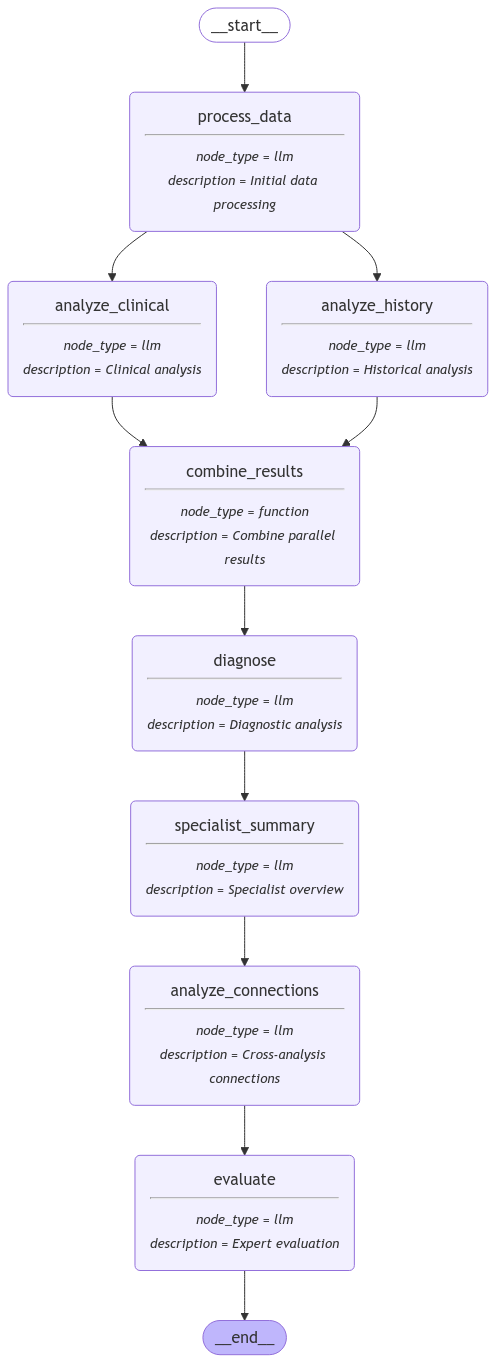

In [10]:
def query_pinecone(query: str, top_k: int = 5, file_type: str = None) -> List[dict]:
    """
    Query Pinecone index for relevant context
    Args:
        query: The query string
        top_k: Number of results to return
        file_type: Optional filter for "case" or "expert" files
    """
    query_embedding = embeddings.embed_query(query)
    index = pc.Index(index_name)

    filter_dict = {"file_type": file_type} if file_type else None

    results = index.query(
        vector=query_embedding, top_k=top_k, include_metadata=True, filter=filter_dict
    )
    return results.matches


def handle_error(state: VetState, error_message: str) -> VetState:
    new_state = state.copy()
    if "errors" not in new_state["results"]:
        new_state["results"]["errors"] = []
    new_state["results"]["errors"].append(
        {
            "timestamp": datetime.now().isoformat(),
            "message": error_message,
            "context": state.get("context", []),
        }
    )
    return new_state


def combine_results(state: VetState) -> VetState:
    new_state = state.copy()
    new_state["results"]["CombinedAnalysis"] = (
        new_state["history_results"] + new_state["clinical_results"]
    )
    return new_state


def create_embeddings_and_index(
    file_content: str, metadata: Dict[str, Any], file_type: str = "case"
) -> None:
    """
    Create embeddings for file content and store in Pinecone
    Args:
        file_content: The content to create embeddings for
        metadata: Additional metadata about the file
        file_type: Either "case" or "expert" to distinguish file types
    """
    try:
        content_embedding = embeddings.embed_query(file_content)
        enhanced_metadata = {
            **metadata,
            "file_type": file_type,
            "text": file_content,
            "embedding_created": datetime.now().isoformat(),
        }

        vector = {
            "id": f"{file_type}_doc_{datetime.now().timestamp()}",
            "values": content_embedding,
            "metadata": enhanced_metadata,
        }

        index = pc.Index(index_name)
        index.upsert(vectors=[vector])

        print(
            f"Successfully created and stored embedding for {file_type} document: {metadata.get('source', 'unknown')}"
        )

    except Exception as e:
        print(f"Error creating embedding for {file_type} document: {str(e)}")
        raise


def process_files(file_paths: List[str], file_type: str = "case") -> List[str]:
    """
    Process files and create embeddings
    Args:
        file_paths: List of file paths to process
        file_type: Either "case" or "expert" to distinguish file types
    Returns: List of file contents
    """
    all_contents = []

    for file_path in file_paths:
        try:
            if file_path.lower().endswith(".pdf"):
                doc = fitz.open(file_path)
                content = ""
                for page in doc:
                    content += page.get_text()
                doc.close()
                if content.strip():
                    all_contents.append(content)

                    metadata = {
                        "source": file_path,
                        "date_processed": datetime.now().isoformat(),
                        "type": "pdf",
                    }
                    create_embeddings_and_index(content, metadata, file_type)

            elif file_path.lower().endswith((".jpg", ".jpeg", ".png")):
                metadata = {
                    "source": file_path,
                    "date_processed": datetime.now().isoformat(),
                    "type": "image",
                }
                print(f"Image file {file_path} processed - metadata stored")

            else:
                print(f"Unsupported file type: {file_path}")

        except Exception as e:
            print(f"Error processing file {file_path}: {str(e)}")
            continue

    return all_contents


def create_evaluation_agent():
    @track_time("evaluate")
    def evaluate_analysis(state: VetState) -> VetState:
        try:
            ai_analysis = {
                "data_processing": state["results"]["DataProcessor"],
                "history": state["results"]["HistoryAnalyzer"],
                "clinical": state["results"]["ClinicalAnalyzer"],
                "diagnostics": state["results"]["Diagnostics"],
                "specialist": state["results"]["SpecialistSummary"],
                "connections": state["results"]["Connections"],
            }

            expert_interpretations = state.get("expert_interpretation", "")

            prompt = ChatPromptTemplate.from_messages(
                [
                    ("system", VET_PROMPTS.BASE_VETERINARY_CONTEXT),
                    ("system", EVALUATION_PROMPTS.EVALUATOR),
                    (
                        "human",
                        """Compare and evaluate the following:

                AI Analysis:
                {ai_analysis}

                Expert Interpretation:
                {expert_interpretation}

                Provide a detailed evaluation following the required format.""",
                    ),
                ]
            )

            messages = prompt.format_messages(
                ai_analysis=json.dumps(ai_analysis, indent=2),
                expert_interpretation=expert_interpretations,
            )
            response = llm.invoke(messages)

            new_state = state.copy()
            new_state["messages"] = [response]
            new_state["results"]["Evaluation"] = response.content

            return new_state

        except Exception as e:
            return handle_error(state, f"Evaluation Error: {str(e)}")

    return evaluate_analysis


def create_data_processing_agent():
    @track_time("process_data")
    def process_data(state: VetState) -> VetState:
        try:
            current_text = state["current_input"]
            if isinstance(current_text, list):
                current_text = "\n\n".join(current_text)
            relevant_docs = query_pinecone(current_text)
            context = [doc.metadata.get("text", "") for doc in relevant_docs]

            if state.get("images"):
                image_context = "Document contains the following images:\n"
                for idx, img in enumerate(state["images"]):
                    image_context += f"\nImage {idx + 1} on page {img['page_num']}:\n"
                    image_context += f"- Type: {img['extension']}\n"
                    image_context += f"- Dimensions: {img['metadata']['width']}x{img['metadata']['height']}\n"
                context.append(image_context)

            context_text = "\n\n".join(context)

            prompt = ChatPromptTemplate.from_messages(
                [
                    ("system", VET_PROMPTS.BASE_VETERINARY_CONTEXT),
                    ("system", VET_PROMPTS.DATA_PROCESSOR),
                    ("human", "Process this veterinary case data in detail: {input}"),
                ]
            )

            messages = prompt.format_messages(
                input=state["current_input"], context=context_text
            )
            response = llm.invoke(messages)

            new_state = state.copy()
            new_state["messages"] = [response]  # Changed from append to assignment
            new_state["results"]["DataProcessor"] = response.content
            new_state["context"] = context

            return new_state

        except Exception as e:
            return handle_error(state, f"Data Processing Error: {str(e)}")

    return process_data


def create_history_analysis_agent():
    @track_time("analyze_history")
    def analyze_history(state: VetState) -> VetState:
        try:
            processed_data = state["results"]["DataProcessor"]
            context = state.get("context", [])

            prompt = ChatPromptTemplate.from_messages(
                [
                    ("system", VET_PROMPTS.BASE_VETERINARY_CONTEXT),
                    ("system", VET_PROMPTS.HISTORY_ANALYZER),
                    (
                        "human",
                        "Analyze this case history with detailed timeline: {processed_data}",
                    ),
                ]
            )

            messages = prompt.format_messages(
                processed_data=processed_data, context="\n\n".join(context)
            )
            response = llm.invoke(messages)

            new_state = state.copy()
            new_state["messages"] = [response]
            new_state["history_results"] = [response.content]
            new_state["results"]["HistoryAnalyzer"] = response.content

            return new_state

        except Exception as e:
            return handle_error(state, f"History Analysis Error: {str(e)}")

    return analyze_history


def create_clinical_analysis_agent():
    @track_time("analyze_clinical")
    def analyze_clinical(state: VetState) -> VetState:
        try:
            # Get both the processed data and history analysis results
            processed_data = state["results"]["DataProcessor"]
            history_analysis = state.get("results", {}).get("HistoryAnalyzer", "")
            context = state.get("context", [])

            # Combine all relevant information
            combined_input = f"""
            Processed Data:
            {processed_data}

            History Analysis:
            {history_analysis}
            """

            prompt = ChatPromptTemplate.from_messages(
                [
                    ("system", VET_PROMPTS.BASE_VETERINARY_CONTEXT),
                    ("system", VET_PROMPTS.CLINICAL_ANALYZER),
                    (
                        "human",
                        "Provide detailed clinical analysis for the following case information: {combined_input}",
                    ),
                ]
            )

            messages = prompt.format_messages(
                combined_input=combined_input, context="\n\n".join(context)
            )
            response = llm.invoke(messages)

            new_state = state.copy()
            new_state["messages"] = [response]
            new_state["clinical_results"] = [response.content]
            new_state["results"]["ClinicalAnalyzer"] = response.content

            return new_state

        except Exception as e:
            return handle_error(state, f"Clinical Analysis Error: {str(e)}")

    return analyze_clinical


def create_diagnostic_agent():
    @track_time("diagnose")
    def diagnose(state: VetState) -> VetState:
        try:
            # Gather all previous analyses
            processed_data = state["results"]["DataProcessor"]
            history_analysis = state["results"].get("HistoryAnalyzer", "")
            clinical_analysis = state["results"].get("ClinicalAnalyzer", "")
            context = state.get("context", [])

            combined_input = f"""
            Processed Data:
            {processed_data}

            History Analysis:
            {history_analysis}

            Clinical Analysis:
            {clinical_analysis}
            """

            diagnostic_context = query_pinecone(combined_input)
            additional_context = [
                doc.metadata.get("text", "") for doc in diagnostic_context
            ]
            combined_context = context + additional_context

            prompt = ChatPromptTemplate.from_messages(
                [
                    ("system", VET_PROMPTS.BASE_VETERINARY_CONTEXT),
                    ("system", VET_PROMPTS.DIAGNOSTICIAN),
                    (
                        "human",
                        "Provide comprehensive diagnostic assessment based on the following case information: {combined_input}",
                    ),
                ]
            )

            messages = prompt.format_messages(
                combined_input=combined_input,
                context="\n\n".join(combined_context),
            )
            response = llm.invoke(messages)

            new_state = state.copy()
            new_state["messages"] = [response]
            new_state["results"]["Diagnostics"] = response.content
            new_state["context"] = combined_context

            return new_state

        except Exception as e:
            return handle_error(state, f"Diagnostic Error: {str(e)}")

    return diagnose


def create_specialist_summary_agent():
    @track_time("summary")
    def generate_summaries(state: VetState) -> VetState:
        try:
            diagnostic_assessment = state["results"]["Diagnostics"]
            context = state.get("context", [])
            prompt = ChatPromptTemplate.from_messages(
                [
                    ("system", VET_PROMPTS.BASE_VETERINARY_CONTEXT),
                    ("system", VET_PROMPTS.SPECIALIST),
                    (
                        "human",
                        "Generate comprehensive specialist assessment for: {diagnostic_assessment}",
                    ),
                ]
            )
            messages = prompt.format_messages(
                diagnostic_assessment=diagnostic_assessment,
                context="\n\n".join(context),
            )
            response = llm.invoke(messages)

            new_state = state.copy()
            new_state["messages"] = [response]  # Changed from append to assignment
            new_state["results"]["SpecialistSummary"] = response.content

            return new_state

        except Exception as e:
            return handle_error(state, f"Specialist Summary Error: {str(e)}")

    return generate_summaries


def create_connections_agent():
    @track_time("connection analyze")
    def analyze_connections(state: VetState) -> VetState:
        try:
            previous_analyses = {
                "data_processing": state["results"]["DataProcessor"],
                "history": state["results"]["HistoryAnalyzer"],
                "clinical": state["results"]["ClinicalAnalyzer"],
                "diagnostics": state["results"]["Diagnostics"],
                "specialist": state["results"]["SpecialistSummary"],
            }

            context = state.get("context", [])
            prompt = ChatPromptTemplate.from_messages(
                [
                    ("system", VET_PROMPTS.BASE_VETERINARY_CONTEXT),
                    ("system", VET_PROMPTS.CONNECTIONS),
                    (
                        "human",
                        "Provide comprehensive case integration analysis for: {previous_analyses}",
                    ),
                ]
            )

            messages = prompt.format_messages(
                previous_analyses=json.dumps(previous_analyses, indent=2),
                context="\n\n".join(context),
            )
            response = llm.invoke(messages)

            new_state = state.copy()
            new_state["messages"] = [response]  # Changed from append to assignment
            new_state["results"]["Connections"] = response.content

            return new_state

        except Exception as e:
            return handle_error(state, f"Connections Analysis Error: {str(e)}")

    return analyze_connections


def create_parallel_workflow(has_expert_interpretation: bool = False):
    workflow = StateGraph(VetState)

    workflow.add_node(
        "process_data",
        create_data_processing_agent(),
        metadata={"node_type": "llm",  "description": "Initial data processing"}
    )
    workflow.add_node(
        "analyze_history",
        create_history_analysis_agent(),
        metadata={"node_type": "llm",  "description": "Historical analysis"}
    )
    workflow.add_node(
        "analyze_clinical",
        create_clinical_analysis_agent(),
        metadata={"node_type": "llm",  "description": "Clinical analysis"}
    )
    workflow.add_node(
        "combine_results",
        combine_results,
        metadata={"node_type": "function", "description": "Combine parallel results"}
    )
    workflow.add_node(
        "diagnose",
        create_diagnostic_agent(),
        metadata={"node_type": "llm",  "description": "Diagnostic analysis"}
    )
    workflow.add_node(
        "specialist_summary",
        create_specialist_summary_agent(),
        metadata={"node_type": "llm",  "description": "Specialist overview"}
    )
    workflow.add_node(
        "analyze_connections",
        create_connections_agent(),
        metadata={"node_type": "llm",  "description": "Cross-analysis connections"}
    )

    if has_expert_interpretation:
        workflow.add_node(
            "evaluate",
            create_evaluation_agent(),
            metadata={"node_type": "llm",  "description": "Expert evaluation"}
        )

    workflow.set_entry_point("process_data")

    workflow.add_edge("process_data", "analyze_history")
    workflow.add_edge("process_data", "analyze_clinical")

    workflow.add_edge(["analyze_history", "analyze_clinical"], "combine_results")

    workflow.add_edge("combine_results", "diagnose")
    workflow.add_edge("diagnose", "specialist_summary")
    workflow.add_edge("specialist_summary", "analyze_connections")

    if has_expert_interpretation:
        workflow.add_edge("analyze_connections", "evaluate")
        workflow.add_edge("evaluate", END)
    else:
        workflow.add_edge("analyze_connections", END)

    return workflow.compile()

def analyze_veterinary_case_parallel(file_paths, expert_interpretation_paths=None):
    """Modified main function with parallel execution"""
    try:
        print("Processing case document(s)...")
        if isinstance(file_paths, str):
            file_paths = [file_paths]

        text_contents = process_files(file_paths, file_type="case")

        if not text_contents:
            raise ValueError("No text content extracted from provided case files")

        expert_interpretation = ""
        has_expert_interpretation = False
        if expert_interpretation_paths:
            try:
                print("Processing expert interpretation(s)...")
                if isinstance(expert_interpretation_paths, str):
                    expert_interpretation_paths = [expert_interpretation_paths]
                expert_contents = process_files(
                    expert_interpretation_paths, file_type="expert"
                )
                expert_interpretation = (
                    "\n\n=== Next Expert Interpretation ===\n\n".join(expert_contents)
                )
                has_expert_interpretation = True
            except Exception as e:
                print(f"Warning: Could not load expert interpretation: {str(e)}")

        initial_state = {
            "messages": [],
            "timings": {},
            "current_input": text_contents[0] if text_contents else "",
            "medical_records": {},
            "results": {
                "DataProcessor": "",
                "HistoryAnalyzer": "",
                "ClinicalAnalyzer": "",
                "Diagnostics": "",
                "SpecialistSummary": "",
                "Connections": "",
                "Evaluation": "",
            },
            "metadata": {
                "file_count": len(file_paths),
                "processed_files": file_paths,
                "total_chunks": len(text_contents),
                "expert_files": (
                    expert_interpretation_paths if expert_interpretation_paths else []
                ),
                "processing_date": datetime.now().isoformat(),
            },
            "context": [],
            "images": [],
            "history_results": [],
            "clinical_results": [],
            "expert_interpretation": expert_interpretation,
        }

        print("Creating parallel workflow...")
        workflow = create_parallel_workflow(has_expert_interpretation)

        start_time = time.time()
        print("Running parallel analysis workflow...")
        result = workflow.invoke(initial_state)
        execution_time = time.time() - start_time

        print(f"Analysis completed in {execution_time:.2f} seconds")

        if isinstance(result, dict):
            result["timings"] = result.get("timings", {})
            result["timings"]["total_execution_time"] = execution_time

        return result

    except Exception as e:
        error_msg = f"Error in parallel analysis: {str(e)}"
        print(error_msg)
        traceback.print_exc()
        return {
            "error": error_msg,
            "results": {
                "errors": [
                    {
                        "timestamp": datetime.now().isoformat(),
                        "message": error_msg,
                        "trace": traceback.format_exc(),
                    }
                ]
            },
        }





workflow = create_parallel_workflow(has_expert_interpretation=True)

graph = workflow.get_graph()

print(graph.draw_mermaid())

display(Image(graph.draw_mermaid_png()))

In [11]:
case_files = [
    "./IMG_5188.jpeg",
    "./IMG_5604.jpeg",
    "./J-VSMR.pdf",
    "./LabReport.pdf",
    "./SP-Doc-1.pdf",
    "./SP-Doc-2.pdf",
    "./SP-Doc-3.pdf",
    "./SP-Imagyst.pdf",
    "./SP-Report-1.pdf",
    "./SP-Report-2.pdf",
    "./Signed-Auth-Form.pdf",
    "./THX - Right Lat.jpeg"
]

expert_interpretation_file= [
    "SP-Output1.pdf",
    "SP-Output2.pdf"
]

result = analyze_veterinary_case_parallel(
    file_paths=case_files,
    expert_interpretation_paths=expert_interpretation_file
)

print("\nAnalysis Results:")
print("-" * 50)

sections = [
    ("Data Processing", "DataProcessor"),
    ("History Analysis", "HistoryAnalyzer"),
    ("Clinical Analysis", "ClinicalAnalyzer"),
    ("Diagnostic Assessment", "Diagnostics"),
    ("Specialist Summary", "SpecialistSummary"),
    ("Connections Analysis", "Connections"),
    ("Evaluation", "Evaluation")
]

for title, key in sections:
    print(f"\n{title}:")
    print("-" * 30)
    print(result["results"].get(key, "Not available"))

if "errors" in result["results"]:
    print("\nErrors encountered:")
    for error in result["results"]["errors"]:
        print(f"- {error['message']} (at {error['timestamp']}")

Processing case document(s)...
Image file ./IMG_5188.jpeg processed - metadata stored
Image file ./IMG_5604.jpeg processed - metadata stored
Successfully created and stored embedding for case document: ./LabReport.pdf
Successfully created and stored embedding for case document: ./SP-Doc-1.pdf
Successfully created and stored embedding for case document: ./SP-Doc-2.pdf
Successfully created and stored embedding for case document: ./SP-Doc-3.pdf
Successfully created and stored embedding for case document: ./SP-Imagyst.pdf
Successfully created and stored embedding for case document: ./SP-Report-1.pdf
Successfully created and stored embedding for case document: ./SP-Report-2.pdf
Image file ./THX - Right Lat.jpeg processed - metadata stored
Processing expert interpretation(s)...
Successfully created and stored embedding for expert document: SP-Output1.pdf
Successfully created and stored embedding for expert document: SP-Output2.pdf
Creating parallel workflow...
Running parallel analysis workf

In [9]:
case_files = [
    "./BB-Input.pdf"
]

expert_interpretation_file= [
    "./BB-Output.pdf"
]

result = analyze_veterinary_case_parallel(
    file_paths=case_files,
    expert_interpretation_paths=expert_interpretation_file
)

print("\nAnalysis Results:")
print("-" * 50)

sections = [
    ("Data Processing", "DataProcessor"),
    ("History Analysis", "HistoryAnalyzer"),
    ("Clinical Analysis", "ClinicalAnalyzer"),
    ("Diagnostic Assessment", "Diagnostics"),
    ("Specialist Summary", "SpecialistSummary"),
    ("Connections Analysis", "Connections"),
    ("Evaluation", "Evaluation")
]

for title, key in sections:
    print(f"\n{title}:")
    print("-" * 30)
    print(result["results"].get(key, "Not available"))

if "errors" in result["results"]:
    print("\nErrors encountered:")

    for error in result["results"]["errors"]:
        print(f"- {error['message']} (at {error['timestamp']}")

Processing case document(s)...
Successfully created and stored embedding for case document: ./BB-Input.pdf
Processing expert interpretation(s)...
Successfully created and stored embedding for expert document: ./BB-Output.pdf
Creating parallel workflow...
Running parallel analysis workflow...
Analysis completed in 43.69 seconds

Analysis Results:
--------------------------------------------------

Data Processing:
------------------------------
**PATIENT SIGNALMENT & CLIENT INFORMATION:**
- Patient: Bugsy Bucek
- ID: CA2543BE
- Species: Canine
- Breed: Shih Tzu
- Age: 8.5 years old
- Sex: Male castrated
- Weight: 9.7 kg
- Microchip: None
- Client: DeVonna Bucek
- ID: 254233
- Address: 17405 Westbury Dr, Louisville, KY 40245, USA
- Phone: (502) 807-2763
- Email: devonnabucek@gmail.com

**PRESENTING COMPLAINT AND HISTORY:**
- Chief Complaint: On-going bladder stone issues
- Duration: Ongoing
- Progression: Multiple episodes of bladder stones with previous treatment at East Point Veterinar